In [3]:
#Big Vs-Visualization

In [5]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
spark = SparkSession.builder \
    .appName("Visualization") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9000") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()


In [7]:
spark

In [9]:
# Define the HDFS file path
hdfs_file_path = "hdfs://hadoop-namenode:9000/user/hdfs/all_anonymized_2015_11_2017_03.csv"

# Load the CSV file
df = spark.read.csv(hdfs_file_path, header=True, inferSchema=True)

# Show the first few rows to verify
df.show()


+------+-------+-------+----------------+-------------------+------------+---------+----------+--------+------------+----------+----------+---------+--------------------+--------------------+---------+
| maker|  model|mileage|manufacture_year|engine_displacement|engine_power|body_type|color_slug|stk_year|transmission|door_count|seat_count|fuel_type|        date_created|      date_last_seen|price_eur|
+------+-------+-------+----------------+-------------------+------------+---------+----------+--------+------------+----------+----------+---------+--------------------+--------------------+---------+
|  ford| galaxy| 151000|            2011|               2000|         103|     NULL|      NULL|    None|         man|         5|         7|   diesel|2015-11-14 13:10:...|2016-01-27 15:40:...| 10584.75|
| skoda|octavia| 143476|            2012|               2000|          81|     NULL|      NULL|    None|         man|         5|         5|   diesel|2015-11-14 13:10:...|2016-01-27 15:40:...| 

In [10]:
#Top 10 Car Make and Model Distribution (No Nulls)

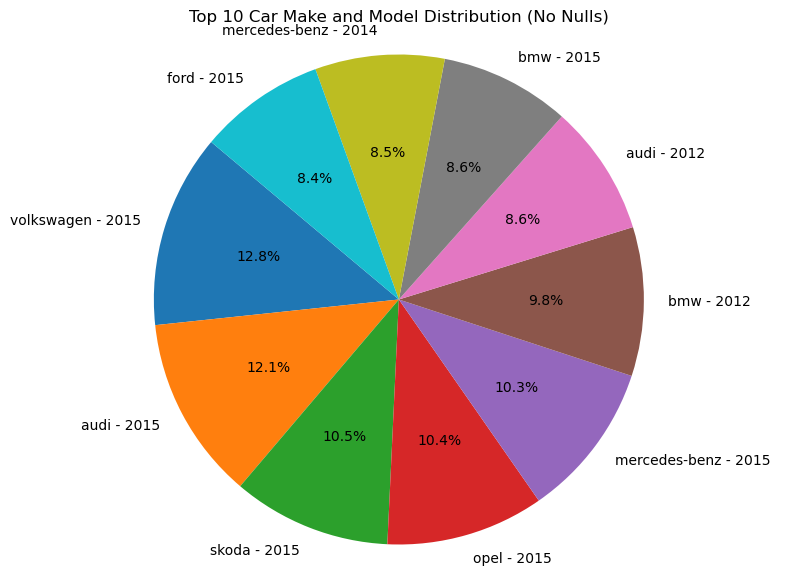

In [11]:
#Filtering out rows with null values for maker and manufacture year
df_filtered = df.dropna(subset=['maker', 'manufacture_year'])
#Grouping by manufacture_year and maker and counting the occurances 
model_make_counts = df_filtered.groupBy('maker', 'manufacture_year').count()
#sorting by count and top 10
model_make_counts_sorted = model_make_counts.orderBy('count', ascending=False).limit(10)
#converting spark to pandas for plotting
model_make_counts_pandas = model_make_counts_sorted.toPandas()
#preparing the data 
labels = [f"{row['maker']} - {row['manufacture_year']}" for index, row in model_make_counts_pandas.iterrows()]
sizes = model_make_counts_pandas['count']


# Plot the Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Top 10 Car Make and Model Distribution (No Nulls)")
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is a circle.
plt.show()


In [12]:
#Price Distribution by Fuel Type

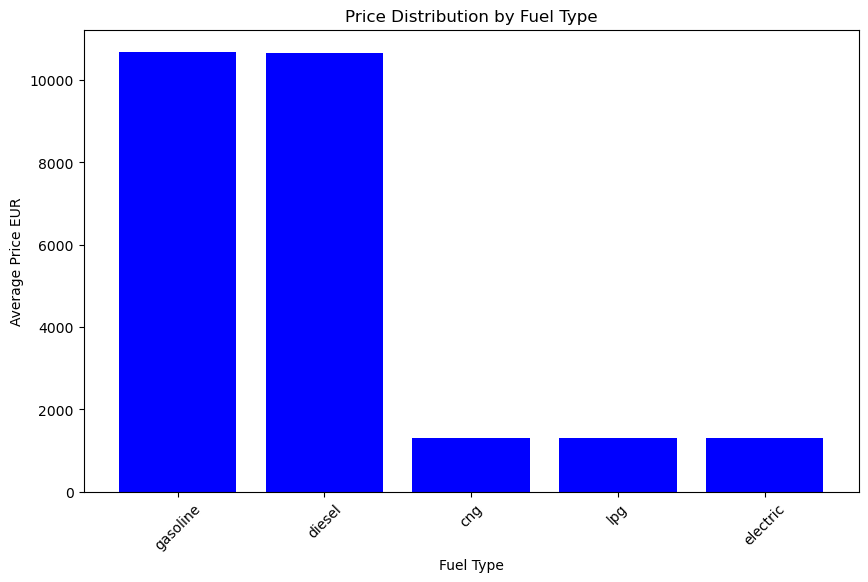

In [13]:
df_filtered_no_nan = df_filtered.dropna(subset=['maker', 'model'])

# Filter out rows where 'fuel_type' is None or null
df_filtered_no_nan_fuel = df_filtered_no_nan.filter(df_filtered_no_nan['fuel_type'].isNotNull())
# Group by 'fuel_type' and calculate the average price for each fuel type
price_by_fuel = df_filtered_no_nan_fuel.groupBy('fuel_type').agg({'price_eur': 'avg'}).orderBy('avg(price_eur)', ascending=False)
# Convert to Pandas DataFrame for easy plotting
price_by_fuel_pandas = price_by_fuel.toPandas()

# Plot price distribution by fuel type
plt.figure(figsize=(10, 6))
plt.bar(price_by_fuel_pandas['fuel_type'], price_by_fuel_pandas['avg(price_eur)'], color='blue')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price EUR')
plt.title('Price Distribution by Fuel Type')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Average Price by Car Body Type

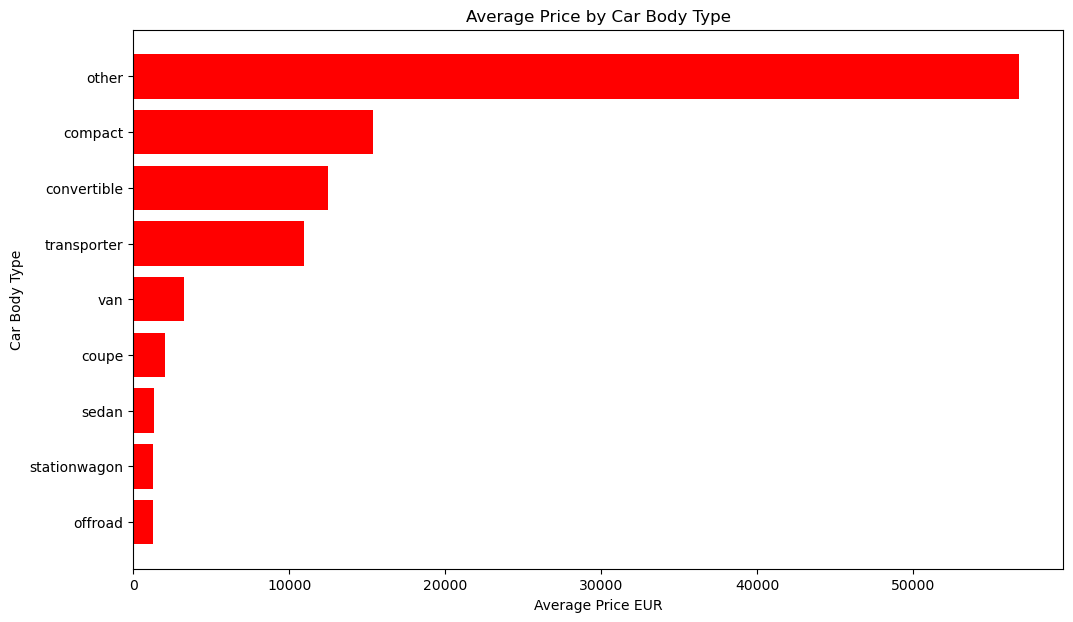

In [15]:
# Filter out rows where 'body_type' is None or null
df_filtered_no_nan_body_type = df_filtered_no_nan.filter(df_filtered_no_nan['body_type'].isNotNull())

# Group by 'body_type' and calculate the average price for each body type
price_by_body_type = df_filtered_no_nan_body_type.groupBy('body_type').agg({'price_eur': 'avg'}).orderBy('avg(price_eur)', ascending=False)

# Convert to Pandas DataFrame for easy plotting
price_by_body_type_pandas = price_by_body_type.toPandas()

# Plot price distribution by body type
plt.figure(figsize=(12, 7))
plt.barh(price_by_body_type_pandas['body_type'], price_by_body_type_pandas['avg(price_eur)'], color='red')
plt.xlabel('Average Price EUR')
plt.ylabel('Car Body Type')
plt.title('Average Price by Car Body Type')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest prices on top
plt.show()

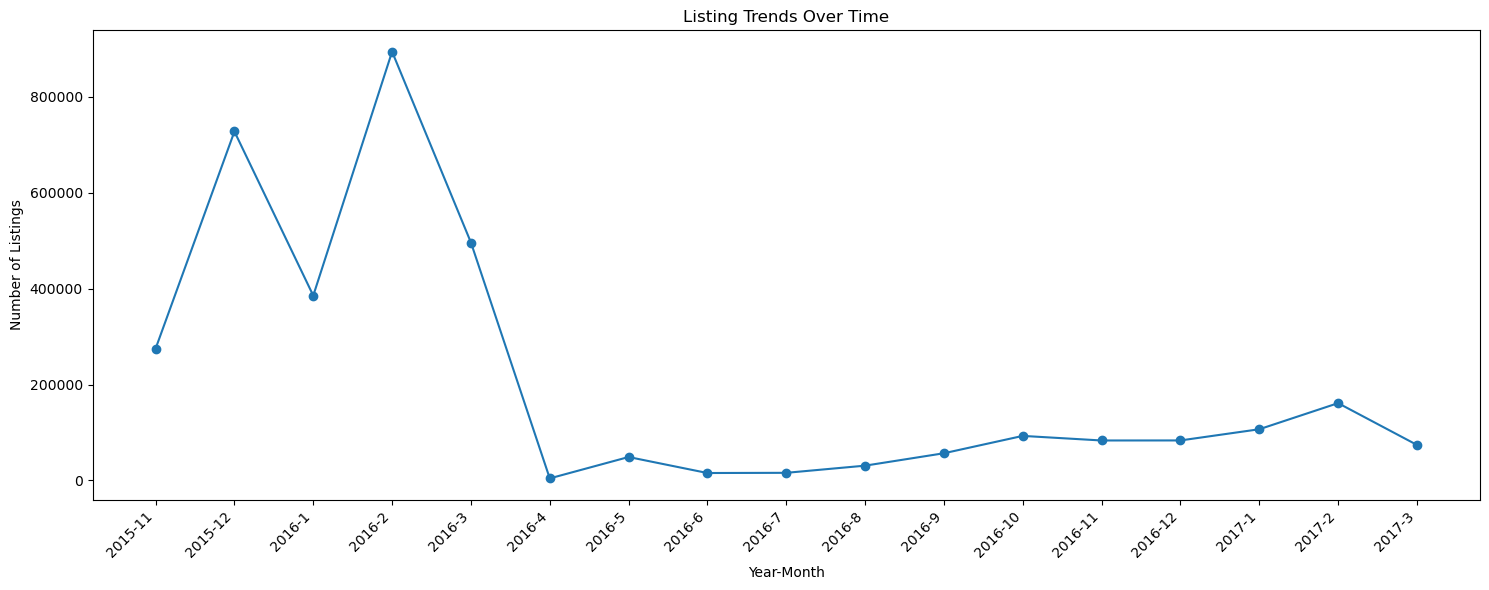

In [27]:

# Listings over time
time_analysis = df.groupBy(
    F.year('date_created').alias('year'),
    F.month('date_created').alias('month')
) \
    .count() \
    .orderBy('year', 'month')

plt.figure(figsize=(15, 6))
time_pdf = time_analysis.toPandas()

# Create x-axis labels
time_pdf['year_month'] = time_pdf['year'].astype(str) + '-' + time_pdf['month'].astype(str)

# Plot the data
plt.plot(time_pdf['year_month'], time_pdf['count'], marker='o')
plt.title('Listing Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

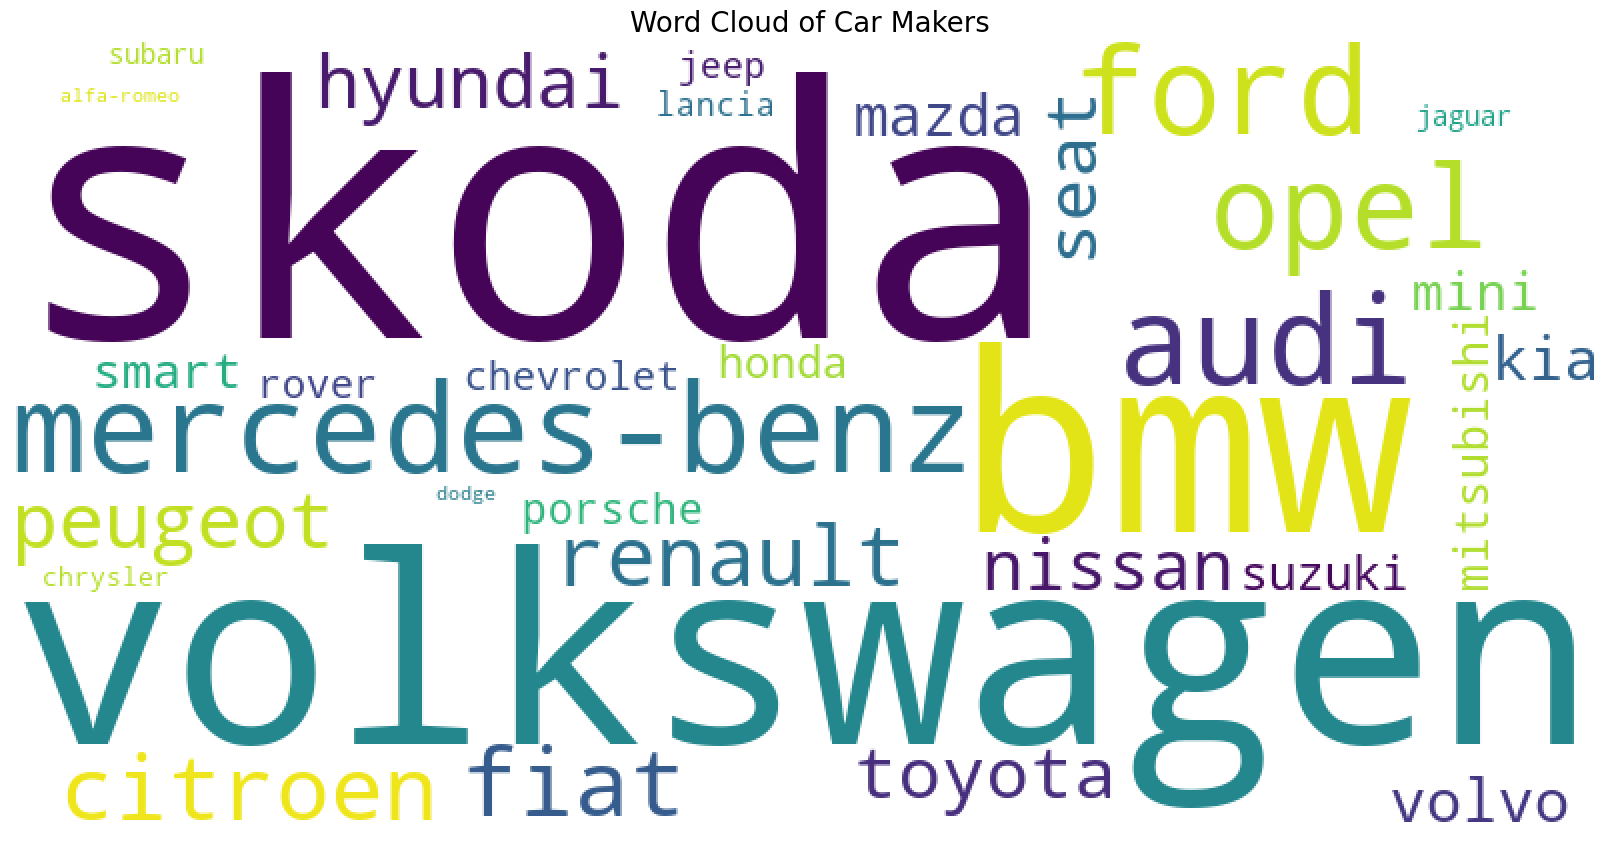

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Count makers
maker_counts = df.groupBy('maker') \
    .agg(count('*').alias('count')) \
    .orderBy(col('count').desc())

# Convert to Pandas DataFrame for word cloud
maker_counts_pd = maker_counts.toPandas()

# Clean and prepare the dictionary
maker_dict = {}
for index, row in maker_counts_pd.iterrows():
    maker = str(row['maker'])  # Ensure maker is a string
    count = row['count']
    
    # Validate the maker and count
    if maker and maker.lower() != 'none' and count > 0:
        maker_dict[maker] = count

# Generate Word Cloud
if maker_dict:  # Check if dictionary is not empty
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        min_font_size=10
    ).generate_from_frequencies(maker_dict)

    # Plotting the Word Cloud
    plt.figure(figsize=(16,8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title("Word Cloud of Car Makers", fontsize=20)
    plt.show()
else:
    print("No valid maker data found to generate word cloud")


In [ ]:
#Big Vs-Volume And Variety And Veracity

In [35]:
df.printSchema()

root
 |-- maker: string (nullable = true)
 |-- model: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- manufacture_year: integer (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_power: integer (nullable = true)
 |-- body_type: string (nullable = true)
 |-- color_slug: string (nullable = true)
 |-- stk_year: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- door_count: string (nullable = true)
 |-- seat_count: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- date_created: timestamp (nullable = true)
 |-- date_last_seen: timestamp (nullable = true)
 |-- price_eur: double (nullable = true)



In [37]:
# Count the number of rows
row_count = df.count()
print(f"Number of rows: {row_count}")

Number of rows: 3552912


In [39]:
df.describe().show()

+-------+----------+-----------------+------------------+------------------+-------------------+------------------+---------+----------+------------------+------------+------------------+------------------+---------+--------------------+
|summary|     maker|            model|           mileage|  manufacture_year|engine_displacement|      engine_power|body_type|color_slug|          stk_year|transmission|        door_count|        seat_count|fuel_type|           price_eur|
+-------+----------+-----------------+------------------+------------------+-------------------+------------------+---------+----------+------------------+------------+------------------+------------------+---------+--------------------+
|  count|   3033997|          2419551|           3190328|           3182334|            2809498|           2998035|  2429998|    209501|           1844756|     2811282|           2938539|           2803423|  1705306|             3552912|
|   mean|  Infinity|500.5487669615217|115814.002

In [41]:
spark.stop()

In [43]:
#MLib

In [45]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MLiB") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9000") \
    .getOrCreate()


In [47]:
spark

In [49]:
# Define the HDFS file path
hdfs_file_path = "hdfs://hadoop-namenode:9000/user/hdfs/all_anonymized_2015_11_2017_03.csv"

# Load the CSV file
df = spark.read.csv(hdfs_file_path, header=True, inferSchema=True)



In [51]:
# Get the column names
columns = df.columns
print(columns)

['maker', 'model', 'mileage', 'manufacture_year', 'engine_displacement', 'engine_power', 'body_type', 'color_slug', 'stk_year', 'transmission', 'door_count', 'seat_count', 'fuel_type', 'date_created', 'date_last_seen', 'price_eur']


In [53]:
# Count null values for each column
from pyspark.sql.functions import col, count, when, isnan

null_counts = df.select([
    count(when(col(c).isNull(), c)).alias(c + '_null_count') 
    for c in df.columns
])
null_counts.show()

df = df.dropna()

+----------------+----------------+------------------+---------------------------+------------------------------+-----------------------+--------------------+---------------------+-------------------+-----------------------+---------------------+---------------------+--------------------+-----------------------+-------------------------+--------------------+
|maker_null_count|model_null_count|mileage_null_count|manufacture_year_null_count|engine_displacement_null_count|engine_power_null_count|body_type_null_count|color_slug_null_count|stk_year_null_count|transmission_null_count|door_count_null_count|seat_count_null_count|fuel_type_null_count|date_created_null_count|date_last_seen_null_count|price_eur_null_count|
+----------------+----------------+------------------+---------------------------+------------------------------+-----------------------+--------------------+---------------------+-------------------+-----------------------+---------------------+---------------------+----------

In [55]:
from pyspark.ml.feature import StringIndexer

# List of categorical columns to encode
categorical_columns = ["maker", "model", "body_type", "fuel_type", "transmission"]


indexers = []
indexed_columns = []


for col_name in categorical_columns:
    index_col_name = col_name + "_index"  # New column name for indexed data
    indexed_columns.append(index_col_name)
    indexers.append(StringIndexer(inputCol=col_name, outputCol=index_col_name))


for indexer in indexers:
    df = indexer.fit(df).transform(df)

In [57]:
columns_to_drop = ["maker", "model", "body_type", "fuel_type", "transmission"]
df = df.drop(*columns_to_drop)


df.printSchema()


root
 |-- mileage: integer (nullable = true)
 |-- manufacture_year: integer (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_power: integer (nullable = true)
 |-- color_slug: string (nullable = true)
 |-- stk_year: string (nullable = true)
 |-- door_count: string (nullable = true)
 |-- seat_count: string (nullable = true)
 |-- date_created: timestamp (nullable = true)
 |-- date_last_seen: timestamp (nullable = true)
 |-- price_eur: double (nullable = true)
 |-- maker_index: double (nullable = false)
 |-- model_index: double (nullable = false)
 |-- body_type_index: double (nullable = false)
 |-- fuel_type_index: double (nullable = false)
 |-- transmission_index: double (nullable = false)



In [59]:
df = df.filter(df["price_eur"].isNotNull()) #Target

In [61]:
from pyspark.ml.feature import VectorAssembler

feature_columns = [
    "maker_index", "model_index", "body_type_index", "fuel_type_index", "transmission_index",
    "mileage", "engine_displacement", "engine_power", "manufacture_year"
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

In [63]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

print(f"Training data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")

Training data count: 3389
Test data count: 838


In [65]:
from pyspark.ml.regression import LinearRegression

# Initialize the model
lr = LinearRegression(featuresCol="features", labelCol="price_eur")

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model
predictions.select("features", "price_eur", "prediction").show()


+--------------------+---------+------------------+
|            features|price_eur|        prediction|
+--------------------+---------+------------------+
|[2.0,4.0,1.0,1.0,...|  18780.0|15232.710773458588|
|[0.0,25.0,3.0,1.0...|  26980.0|18400.090742931352|
|[0.0,25.0,3.0,1.0...|  26980.0|18400.090742931352|
|[6.0,72.0,1.0,0.0...|  22500.0|15737.672683882061|
|[6.0,72.0,1.0,0.0...|  22500.0|15737.672683882061|
|[9.0,49.0,0.0,0.0...|  10980.0| 8149.300648141885|
|[26.0,155.0,3.0,1...| 106505.0| 37255.56781415397|
|[23.0,77.0,5.0,1....|  47500.0|28742.565383572888|
|[3.0,6.0,1.0,0.0,...|  10998.0| 9740.758323316113|
|[8.0,12.0,2.0,0.0...|  28995.0|28512.375024127017|
|[9.0,49.0,0.0,0.0...|  15591.0|11676.760030320438|
|[2.0,129.0,1.0,0....|  16990.0|13209.299949726439|
|[5.0,0.0,2.0,1.0,...|   2400.0| 9425.856977909803|
|[13.0,108.0,1.0,0...|  15990.0|14848.589725134021|
|[0.0,1.0,0.0,0.0,...|   8490.0| 5637.051386050065|
|[5.0,0.0,2.0,0.0,...|  15500.0| 8179.357579427422|
|[1.0,9.0,0.

In [66]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluators
rmse_evaluator = RegressionEvaluator(labelCol="price_eur", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="price_eur", predictionCol="prediction", metricName="r2")

# Calculate metrics
rmse = rmse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")


Root Mean Squared Error (RMSE): 8368.558279792525
R-squared: 0.6037241082417488


In [69]:
spark.stop()